In [2]:
import pandas as pd
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, AvgPool2D, Flatten, BatchNormalization, Activation
from keras.callbacks import LearningRateScheduler
import tensorflow as tf
from os import listdir
import matplotlib.pyplot as plt
from tensorflow.keras.backend import clear_session
from random import seed, randint


Using TensorFlow backend.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def get_preprocessed_data(path):
    # Load data
    data = pd.read_pickle(path)
    print(data.keys())
    (X_train, Y_train, X_val, Y_val, X_test, Y_test) = (data['x_train'], data['y_train'], data['x_validation'], 
                                                    data['y_validation'], data['x_test'], data['y_test']) 
    # Reshape the X_data & encode Y_data
    X_train = np.transpose(X_train, (0, 2, 3, 1))
    X_val = np.transpose(X_val, (0, 2, 3, 1))
    X_test = np.transpose(X_test, (0, 2, 3, 1))

    Y_train = to_categorical(Y_train, num_classes=43)
    Y_val = to_categorical(Y_val, num_classes=43)
    Y_test = to_categorical(Y_test, num_classes=43)

    print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [0]:
class model():
    def __init__(self, input_shape, mode, kernel_size):
        self.input_shape = input_shape
        self.mode = mode
        self.kernel_size = kernel_size
        if mode == 'v1':
            self.model = self.create_model_original()
            self.model.compile(optimizer='adam',
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])
        else:
            if mode == 'v2':
                self.model = self.create_model_student(pruning = 0)
            elif mode == 'v2_p50':
                self.model = self.create_model_student(pruning = 50)
            elif mode == 'v2_p70':
                self.model = self.create_model_student(pruning = 70)
            self.model.compile(optimizer='adam',
                                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                metrics=['accuracy'])        
            
    # Kaggle original model
    def create_model_original(self):
        model = Sequential(name = self.mode)
        model.add(Conv2D(32, kernel_size=self.kernel_size, padding='same', activation='relu', input_shape=self.input_shape))
        model.add(MaxPool2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))
        model.add(Dense(43, activation='softmax'))
        return model

    # Paper's student model
    def create_model_student(self, pruning):
        if pruning == 0:
            filters_num = [64, 64, 128, 128, 256]
        elif pruning == 50:
            filters_num = [32, 32, 64, 64, 128]
        else:
            filters_num = [21, 54, 44, 29, 43] 

        model = Sequential(name = self.mode)
        model.add(Conv2D(filters_num[0], (3, 3), strides=(1,1), padding= 'SAME', input_shape = self.input_shape)) # output 32*32
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv2D(filters_num[1], (3, 3), strides=(1,1), padding= 'SAME')) # output 32*32
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(MaxPool2D(pool_size=(2,2), strides = (2,2), padding='VALID' )) #  output 16*16

        model.add(Conv2D(filters_num[2], (3, 3), strides=(1,1),  padding= 'SAME')) # output 16*16
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv2D(filters_num[3], (3, 3), strides=(1,1), padding= 'SAME')) # output 16*16
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(MaxPool2D(pool_size=(2,2), strides = (2,2), padding= 'VALID')) #  output 8*8

        model.add(Conv2D(filters_num[4], (3, 3), strides=(1,1), padding= 'SAME')) # output 8*8
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(AvgPool2D(pool_size=(2,2), strides = (2,2), padding= 'VALID')) #  output 4*4
        model.add(Flatten()) # output - 4096
        model.add(Dense(43)) # 43 classes of output labels
        return model

    def train(self, X_train, Y_train, epochs, batch_size, validation_data, callbacks=False):
        if self.mode == 'v1':
            self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=validation_data, callbacks=[callbacks])
        else:
            self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=validation_data)        

    def accuracy(self, x, y):
        results = self.model.evaluate(x, y)
        print(self.mode, 'test loss, test acc:', results)
        return results
    def get_predict(self, x):
        return self.model.predict(x)

### Kernel varience of the original model

In [0]:
# Models summary of diff. kernel sizes
clear_session()
filters = [3, 5, 9, 13, 15, 19, 23, 25, 31]
# Create 9 models
model = [0] * len(filters)
for i in range(len(model)):
    model[i] = Sequential()
    model[i].add(Conv2D(32, kernel_size=filters[i], padding='same', activation='relu', input_shape=(32, 32, 3)))
    model[i].add(MaxPool2D(pool_size=2))
    model[i].add(Flatten())
    model[i].add(Dense(500, activation='relu'))
    model[i].add(Dense(43, activation='softmax'))
    model[i].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model[i].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               4096500   
_________________________________________________________________
dense_2 (Dense)              (None, 43)                21543     
Total params: 4,118,939
Trainable params: 4,118,939
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)          

In [0]:
def create_v1_models(filters, input_shape):
    models = [0] * len(filters)
    for i in range(len(models)):
        models[i] = model(input_shape, mode = 'v1', name = filename, kernel_size = filters[i])
    return model

def plot_v1_acc(filters, model_v1_accuracies):
    legend = []   # Convert filter size name from int to str
    for filter_size in filters:
        legend.append(str(filter_size))
    plt.rcParams['figure.figsize'] = (15.0, 5.0) # Setting default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['font.family'] = 'Times New Roman'
    fig = plt.figure()
    for i in range(len(tmp)):
        plt.plot(tmp[i], '-o', linewidth=0.5)
    plt.title('Accuracy of models', fontsize=22)
    plt.legend(legend, loc='lower right', fontsize='x-large')
    plt.xlabel('Data File Number', fontsize=20)
    plt.ylabel('Accuracy of Testing Data', fontsize=20)
    plt.tick_params(labelsize=18)
    plt.show()

def kernel_test():
    clear_session()
    path = 'drive/Shared drives/258/data/preprocessed/'
    model_v1_accuracies = np.zeros(shape = (9, 9))  # 9 files, 9 models
    epchos_v1, batch_size_v1, file_number = 5, 5, 0
    annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epchos_v1))
    filters = [3, 5, 9, 13, 15, 19, 23, 25, 31]
    # Traverse 9 files
    for filename in sorted(listdir(path)):
        print('===================================================================================================================================')
        print('File: ', filename)
        X_train, Y_train, X_val, Y_val, X_test, Y_test = get_preprocessed_data(path+filename)
        # Create models with diff. filter size
        model = create_v1_models(filters, input_shape=X_train.shape[1:])
        # Train the models
        for i in range(len(model)):
            model[i].fit(X_train, Y_train, batch_size=batch_size_v1, epochs = epchos_v1,
                          validation_data = (X_val, Y_val), callbacks=[annealer], verbose=0)
            results = model[i].evaluate(X_test, Y_test)
            print('model filter size:', filters[i], 'test loss, test acc:', results)
            [loss, acc] = results
            model_v1_accuracies[file_number][i] = acc
        file_number+=1
    return model_v1_accuracies

In [0]:
model_v1_accuracies = kernel_test()

File:  data0.pickle
dict_keys(['x_test', 'y_validation', 'x_validation', 'labels', 'x_train', 'y_test', 'y_train'])
(86989, 32, 32, 3) (4410, 32, 32, 3) (12630, 32, 32, 3) (86989, 43) (4410, 43) (12630, 43)
12630/12630 [==============================] - 1s 74us/step
model filter size: 3 test loss, test acc: [3.7603733223766347, 0.8079968094825745]
12630/12630 [==============================] - 1s 72us/step
model filter size: 5 test loss, test acc: [5.154060434445633, 0.7482185363769531]
12630/12630 [==============================] - 1s 75us/step
model filter size: 9 test loss, test acc: [4.210052829796798, 0.10601741820573807]
12630/12630 [==============================] - 1s 78us/step
model filter size: 13 test loss, test acc: [3.7592112686930435, 0.011876484379172325]
12630/12630 [==============================] - 1s 78us/step
model filter size: 15 test loss, test acc: [3.7611071155076923, 0.0047505940310657024]
12630/12630 [==============================] - 1s 82us/step
model filter

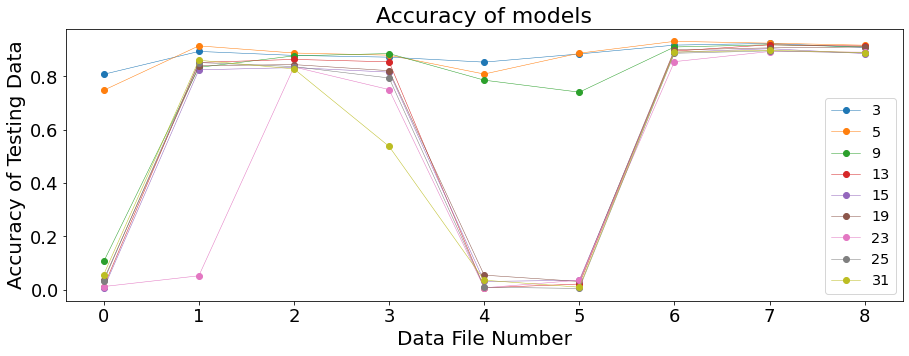

In [0]:
filters = [3, 5, 9, 13, 15, 19, 23, 25, 31]
plot_v1_acc(filters, model_v1_accuracies)

###Train & get the accuracies of four models (1 original model & 3 student models) in 9 files

In [0]:
def test_models():
    clear_session()
    path = 'drive/Shared drives/258/data/preprocessed/'
    models_acc = np.zeros(shape = (4,9))   # 4 models, 9 files
    epchos_v1, epchos_v2, batch_size_v1,  batch_size_v2 = 5, 10, 5, 128
    annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epchos_v1))
    modes = ['v1', 'v2', 'v2_p50', 'v2_p70']
    file_num = 0
    for filename in sorted(listdir(path)):
        print('===================================================================================================================================')
        print('File: ', filename)
        # Get the data from path
        X_train, Y_train, X_val, Y_val, X_test, Y_test = get_preprocessed_data(path+filename)
        input_shape = X_train.shape[1:]     #(32,32,3) or (32,32,1)
        # Train the 4 models
        for i in range(len(modes)):
            model_tmp = model(input_shape, mode = modes[i], kernel_size = 3)
            if modes[i] == 'v1':  # Original model
                model_tmp.train(X_train, Y_train, epchos_v1, batch_size_v1, validation_data=(X_val, Y_val), callbacks=annealer)
            else:   # Student model
                model_tmp.train(X_train, Y_train, epchos_v2, batch_size_v2, validation_data=(X_val, Y_val))
            # Get the acc. of test data
            [loss, acc] = model_tmp.accuracy(X_test, Y_test)
            models_acc[i][file_num] = acc
            print('model ', i, 'file_num: ', file_num, 'acc: ', models_acc[i][file_num])
        file_num+=1
    # Plot the accuracies
    plot_acc(models_acc)

def plot_acc(acc_array2D):
    plt.rcParams['figure.figsize'] = (15.0, 5.0) # Setting default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    fig = plt.figure()
    # Plot the accuracies of the 4 models
    for i in range(acc_array2D.shape[0]):
        plt.plot(acc_array2D[i], '-o', linewidth=3.0)
    plt.title('Accuracy of models', fontsize=22)
    plt.legend(['original model', 'student model', 'student model 50% pruned', 'student model 70% pruned'], loc='lower right', fontsize='x-large')
    plt.xlabel('Data File Number', fontsize=20)
    plt.ylabel('Accuracy of Testing Data', fontsize=20)
    plt.tick_params(labelsize=18)
    # Showing the plot
    plt.show()

File:  data0.pickle
dict_keys(['x_test', 'y_validation', 'x_validation', 'labels', 'x_train', 'y_test', 'y_train'])
(86989, 32, 32, 3) (4410, 32, 32, 3) (12630, 32, 32, 3) (86989, 43) (4410, 43) (12630, 43)
12630/12630 [==============================] - 1s 95us/step
v1 test loss, test acc: [4.895119748314694, 0.8039588332176208]
12630/12630 [==============================] - 2s 178us/step
v2 test loss, test acc: [0.11803452713814691, 0.9691211581230164]
12630/12630 [==============================] - 2s 156us/step
v2_p50 test loss, test acc: [0.08808113166997926, 0.9790182113647461]
12630/12630 [==============================] - 2s 145us/step
v2_p70 test loss, test acc: [0.30328512928748735, 0.931037187576294]
File:  data1.pickle
dict_keys(['x_train', 'y_test', 'x_test', 'x_validation', 'labels', 'y_train', 'y_validation'])
(86989, 32, 32, 3) (4410, 32, 32, 3) (12630, 32, 32, 3) (86989, 43) (4410, 43) (12630, 43)
12630/12630 [==============================] - 1s 90us/step
v1 test loss, 

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


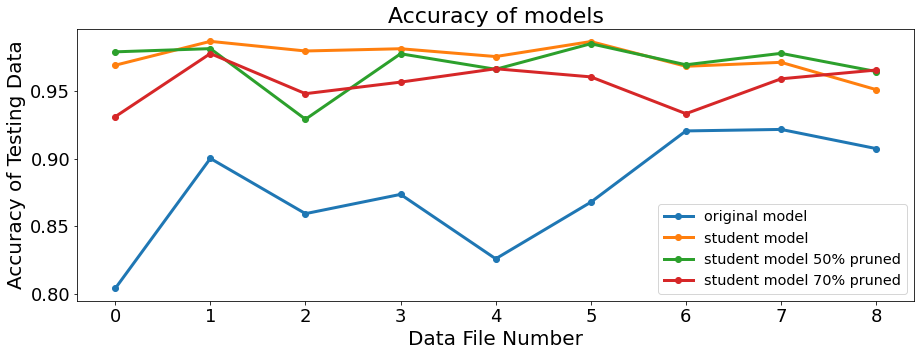

In [0]:
test_models()

###Some prediction of 70% pruned student model

In [7]:
# Load the data from "data1.pickle"
clear_session()
path = 'drive/Shared drives/258/data/preprocessed/'
filename = 'data1.pickle'
X_train, Y_train, X_val, Y_val, X_test, Y_test = get_preprocessed_data(path+filename)

dict_keys(['x_train', 'y_test', 'x_test', 'x_validation', 'labels', 'y_train', 'y_validation'])
(86989, 32, 32, 3) (4410, 32, 32, 3) (12630, 32, 32, 3) (86989, 43) (4410, 43) (12630, 43)


In [12]:
# Train the 70% pruned student model
clear_session()
input_shape = X_train.shape[1:]
model_tmp = model(input_shape, mode = 'v2_p70', kernel_size = 3)
model_tmp.train(X_train, Y_train, 10, 128, validation_data=(X_val, Y_val))
result = model_tmp.accuracy(X_test, Y_test)

Train on 86989 samples, validate on 4410 samples
Epoch 1/10
86989/86989 [==============================] - 29s 331us/step - loss: 0.6162 - accuracy: 0.8509 - val_loss: 0.2304 - val_accuracy: 0.9299
Epoch 2/10
86989/86989 [==============================] - 20s 232us/step - loss: 0.0405 - accuracy: 0.9926 - val_loss: 0.2262 - val_accuracy: 0.9358
Epoch 3/10
86989/86989 [==============================] - 21s 237us/step - loss: 0.0169 - accuracy: 0.9968 - val_loss: 0.1150 - val_accuracy: 0.9680
Epoch 4/10
86989/86989 [==============================] - 21s 238us/step - loss: 0.0101 - accuracy: 0.9981 - val_loss: 0.0975 - val_accuracy: 0.9692
Epoch 5/10
86989/86989 [==============================] - 21s 238us/step - loss: 0.0079 - accuracy: 0.9985 - val_loss: 0.1154 - val_accuracy: 0.9676
Epoch 6/10
86989/86989 [==============================] - 20s 233us/step - loss: 0.0093 - accuracy: 0.9977 - val_loss: 0.0876 - val_accuracy: 0.9721
Epoch 7/10
86989/86989 [==============================] -

Real class:  25


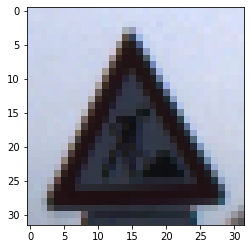

Predicted class:  25
Sign Name:  Road work 



Real class:  12


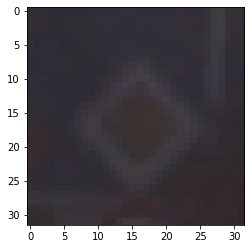

Predicted class:  12
Sign Name:  Priority road 



Real class:  8


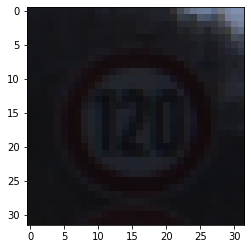

Predicted class:  8
Sign Name:  Speed limit (120km/h) 



Real class:  1


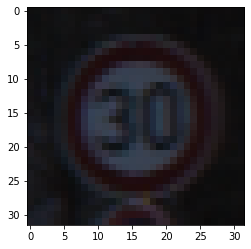

Predicted class:  1
Sign Name:  Speed limit (30km/h) 



Real class:  12


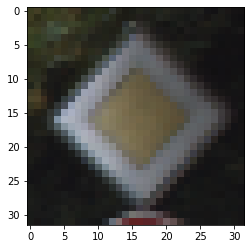

Predicted class:  12
Sign Name:  Priority road 



Real class:  38


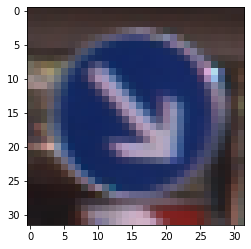

Predicted class:  38
Sign Name:  Keep right 



Real class:  39


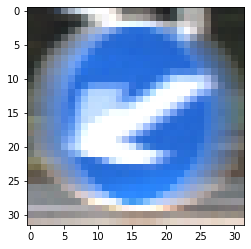

Predicted class:  39
Sign Name:  Keep left 



Real class:  38


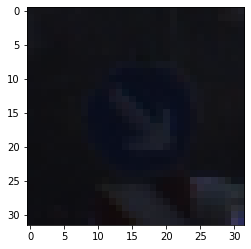

Predicted class:  38
Sign Name:  Keep right 



Real class:  5


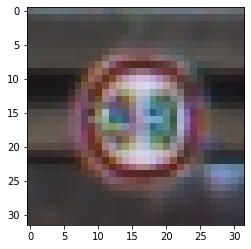

Predicted class:  7
Sign Name:  Speed limit (100km/h) 



Real class:  6


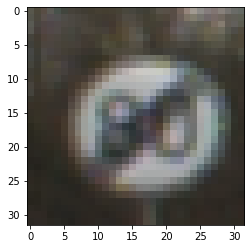

Predicted class:  6
Sign Name:  End of speed limit (80km/h) 





In [32]:
# Get prediction from 10 random test images
def get_prediction(model, test_img, img_label, label_names):
    print("Real class: ", np.argmax(img_label))
    plt.imshow(test_img)
    plt.show()

    label = np.argmax(model.get_predict(test_img.reshape(-1,  32, 32, 3)), axis=1)[0]
    print("Predicted class: ", label)
    print("Sign Name: ", label_names['SignName'][label], '\n')

label_names = pd.read_csv('drive/Shared drives/258/data/label_names.csv')
seed(1)
for _ in range(10):
    val = randint(0, 43)
    get_prediction(model_tmp, X_test[val,:,:,:], Y_test[val], label_names)
    print("\n")